Species: ['X', 'complex_Y_2x_Z_', 'Y', 'complex_X_2x_Y_Z_', 'complex_X_2x_Z_', 'complex_Y_2x_', 'complex_X_Y_2x_Z_', 'Z', 'complex_X_2x_']

Original System:
dX/dt = -2.0*X**2*kb__ - X*complex_Y_2x_Z_*kb__ + 2.0*complex_X_2x_*ku__ + complex_X_Y_2x_Z_*ku__
dcomplex_Y_2x_Z_/dt = -X*complex_Y_2x_Z_*kb__ + Z*complex_Y_2x_*kb__ + complex_X_Y_2x_Z_*ku__ - complex_Y_2x_Z_*ku__
dY/dt = -2.0*Y**2*kb__ - Y*complex_X_2x_Z_*kb__ + complex_X_2x_Y_Z_*ku__ + 2.0*complex_Y_2x_*ku__
dcomplex_X_2x_Y_Z_/dt = Y*complex_X_2x_Z_*kb__ - complex_X_2x_Y_Z_*ku__
dcomplex_X_2x_Z_/dt = -Y*complex_X_2x_Z_*kb__ + Z*complex_X_2x_*kb__ + complex_X_2x_Y_Z_*ku__ - complex_X_2x_Z_*ku__
dcomplex_Y_2x_/dt = Y**2*kb__ - Z*complex_Y_2x_*kb__ - complex_Y_2x_*ku__ + complex_Y_2x_Z_*ku__
dcomplex_X_Y_2x_Z_/dt = X*complex_Y_2x_Z_*kb__ - complex_X_Y_2x_Z_*ku__
dZ/dt = -Z*complex_X_2x_*kb__ - Z*complex_Y_2x_*kb__ + complex_X_2x_Z_*ku__ + complex_Y_2x_Z_*ku__
dcomplex_X_2x_/dt = X**2*kb__ - Z*complex_X_2x_*kb__ - complex_X_2x_*ku__

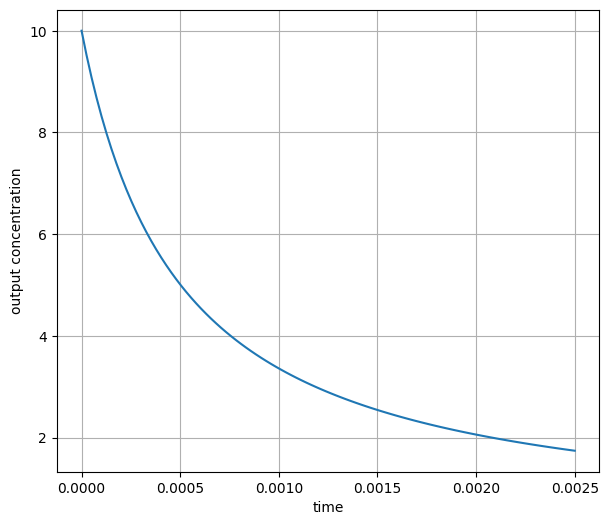

In [100]:
from autoreduce.converters import load_sbml
from sympy import Symbol
import numpy as np

# Load the CRN
sys = load_sbml("example6.xml", outputs = "X")

# Set initial conditions
x0_dict = {"X": 10}
for x, x_ic in x0_dict.items():
    curr_ind = sys.x.index(Symbol(x))
    sys.x_init[curr_ind] = x_ic

# Print species
print("Species:", [str(s) for s in sys.x])

# Print original system ODEs
print("\nOriginal System:")
for i, eq in enumerate(sys.f):
    print(f"d{sys.x[i]}/dt = {eq}")

from autoreduce.utils import get_ODE
import matplotlib.pyplot as plt 
import numpy as np 

species_names = [str(s) for s in sys.x]

timepoints_ode = np.linspace(0, 0.0025, 100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T  
plt.figure(figsize = (7,6))

full_model = np.transpose(np.array(sys.C)@sol)
plt.plot(timepoints_ode, full_model)
plt.xlabel('time')
plt.ylabel('output concentration')
plt.grid(True)
plt.show()















min value (concentration) of X during simulation: 1.7408267961397486
max value (concentration) of X during simulation: 10.0

half-life concentration value: 5.0

half-life time value: 0.000505050505050505

contract created:
InVars: [time]
OutVars:[x_output]
A: [
  -time <= -0.0005
]
G: [
  x_output <= 5
  -x_output <= 0
  time <= 0.0025
]


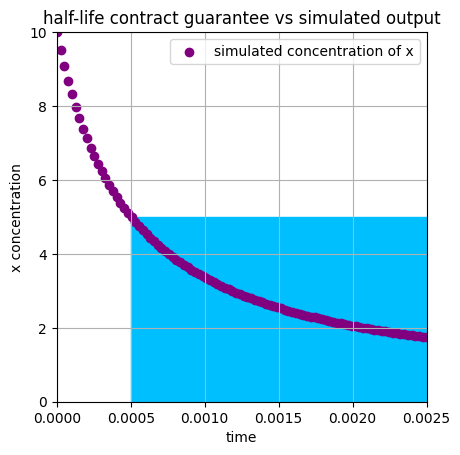

In [106]:
from pacti.contracts import PolyhedralIoContract
from pacti.utils.plots import plot_guarantees
from pacti.iocontract import Var
import matplotlib.pyplot as plt
import numpy as np

# Assuming sys_ode and sol are already defined from your ODE solution

# Compute X_t (concentration matrix) and min/max X for reporting
X_t = np.transpose(np.array(sys.C @ sol))
min_X = X_t.min()
max_X = X_t.max()

half_life_x = x_output_data[0] / 2 

closest_idx = np.argmin(np.abs(x_output_data - half_life_x)) 

half_life_time = timepoints_ode[closest_idx]



print(f"min value (concentration) of X during simulation: {min_X}")
print(f"max value (concentration) of X during simulation: {max_X}\n")
print(f"half-life concentration value: {half_life_x}\n")
print(f"half-life time value: {half_life_time}\n")

# Extract the timepoints and x_output_data (first species column)
timepoints_ode = np.linspace(0, 0.0025, X_t.shape[0])
x_output_data = X_t[:, 0]

# Define your contract: assumption + bounded guarantee region for plotting
contract1 = PolyhedralIoContract.from_dict({
    "assumptions": [
        {"coefficients": {"time": -1}, "constant": -0.0005}   # time >= 0.00075
    ],
    "guarantees": [
        {"coefficients": {"x_output": 1}, "constant": 5},       # x_output <= 5
        {"coefficients": {"x_output": -1}, "constant": 0},      # x_output >= 0
        {"coefficients": {"time": -1}, "constant": 0},          # time >= 0
        {"coefficients": {"time": 1}, "constant": 0.0025}       # time <= 0.0025
    ],
    "input_vars": ["time"],
    "output_vars": ["x_output"]
})


print("contract created:")
print(contract1)

# Plot the guarantee region
fig = plot_guarantees(
    contract=contract1,
    x_var=Var("time"),
    y_var=Var("x_output"),
    var_values={},
    x_lims=(0, 0.0025),
    y_lims=(0, 10)
)

# Overlay the simulation data
plt.scatter(timepoints_ode, x_output_data, color="purple", label="simulated concentration of x")
plt.xlabel("time")
plt.ylabel("x concentration")
plt.title("half-life contract guarantee vs simulated output")
plt.legend()
plt.grid(True)
plt.show()
